## PAW wavelet decomposition

In [272]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Reposiktories/'

In [273]:
""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
import pandas as pd
from one.api import ONE
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy import stats
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns
# Get my functions
from functions import idxs_from_files, fast_wavelet_morlet_convolution_parallel, plot_kde, get_speed, GMM_neg_log_likelihood
one = ONE(mode='remote')

In [274]:
""" 
LOAD DATA AND PARAMETERS
"""
# LOAD DATA

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
results_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

# Wavelet decomposition
f = np.array([.25, .5, 1, 2, 4, 8, 16, 32])
omega0 = 5
velocity = True

In [275]:
# Loop through animals
files = os.listdir(results_path)
sessions_to_process = []

for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]

    """ SAVE DATA """       
    # Save wavelets
    if velocity:
        subname = "paw_vel_wavelets_"
    else:
        subname = "paw_pos_wavelets_"
    filename = subname + str(session) + '_'  + mouse_name

    if filename not in files:
        sessions_to_process.append((session))

len(sessions_to_process)

0

# Paw wavelets

In [276]:
import scipy.interpolate as interpolate


def smooth_interpolate_signal_sg(signal, window=11, order=3, interp_kind='cubic'):
    """Run savitzy-golay filter on signal, interpolate through nan points.
    
    Parameters
    ----------
    signal : np.ndarray
        original noisy signal of shape (t,), may contain nans
    window : int
        window of polynomial fit for savitzy-golay filter
    order : int
        order of polynomial for savitzy-golay filter
    interp_kind : str
        type of interpolation for nans, e.g. 'linear', 'quadratic', 'cubic'

    Returns
    -------
    np.array
        smoothed, interpolated signal for each time point, shape (t,)
        
    """

    signal_noisy_w_nans = np.copy(signal)
    timestamps = np.arange(signal_noisy_w_nans.shape[0])
    good_idxs = np.where(~np.isnan(signal_noisy_w_nans))[0]
    # perform savitzky-golay filtering on non-nan points
    signal_smooth_nonans = non_uniform_savgol(
        timestamps[good_idxs], signal_noisy_w_nans[good_idxs], window=window, polynom=order)
    signal_smooth_w_nans = np.copy(signal_noisy_w_nans)
    signal_smooth_w_nans[good_idxs] = signal_smooth_nonans
    # interpolate nan points
    interpolater = interpolate.interp1d(
        timestamps[good_idxs], signal_smooth_nonans, kind=interp_kind, fill_value='extrapolate')

    signal = interpolater(timestamps)

    return signal


def non_uniform_savgol(x, y, window, polynom):
    """Applies a Savitzky-Golay filtepathstions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    https://dsp.stackexchange.com/a/64313

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array
        The smoothed y values
    """

    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))  # Matrix
    tA = np.empty((polynom, window))  # Transposed matrix
    t = np.empty(window)  # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]
        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]
        # Multiply the two matrices
        tAA = np.matmul(tA, A)
        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)
        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)
        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]
        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]
    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]
    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]
    return y_smoothed


In [277]:
# This function uses get_XYs, not smoothing, is closer to brainbox function: https://github.com/int-brain-lab/ibllib/blob/78e82df8a51de0be880ee4076d2bb093bbc1d2c1/brainbox/behavior/dlc.py#L63
def get_speed(poses, times, camera, split, feature, smooth):
    """
    FIXME Document and add unit test!

    :param dlc: dlc pqt table
    :param dlc_t: dlc time points
    :param camera: camera type e.g 'left', 'right', 'body'
    :param feature: dlc feature to compute speed over
    :return:
    """
    SAMPLING = {'left': 60,
                'right': 150,
                'body': 30}
    RESOLUTION = {'left': 2,
                  'right': 1,
                  'body': 1}

    speeds = {}
    times = np.array(times)
    x = poses[f'{feature}_x'] / RESOLUTION[camera]
    y = poses[f'{feature}_y'] / RESOLUTION[camera]

    dt = np.diff(times)
    tv = times[:-1] + dt / 2


    # Calculate velocity for x and y separately if split is true
    if split == True:
        s_x = np.diff(x) * SAMPLING[camera]
        s_y = np.diff(y) * SAMPLING[camera]
        if smooth:
            speeds = [times, smooth_interpolate_signal_sg(s_x), smooth_interpolate_signal_sg(s_y)]
        else:
            speeds = [times, s_x, s_y]
        # interpolate over original time scale
        if tv.size > 1:
            ifcn_x = interpolate.interp1d(tv, s_x, fill_value="extrapolate")
            ifcn_y = interpolate.interp1d(tv, s_y, fill_value="extrapolate")
            if smooth:
                speeds = [times, smooth_interpolate_signal_sg(ifcn_x(times)), smooth_interpolate_signal_sg(ifcn_y(times))]
            else:
                speeds = [times, ifcn_x(times), ifcn_y(times)]
    else:
        # Speed vector is given by the Pitagorean theorem
        s = ((np.diff(x)**2 + np.diff(y)**2)**.5) * SAMPLING[camera]
        speeds = [times, s]
        # interpolate over original time scale
        if tv.size > 1:
            ifcn = interpolate.interp1d(tv, s, fill_value="extrapolate")
            if smooth:
                speeds = [times, smooth_interpolate_signal_sg(ifcn(times))]
            else:
                speeds = [times, ifcn(times)]

    return speeds  

In [374]:
concatenated_subsampled = np.array([])
paws = ['l_paw', 'r_paw']

for m, mat in enumerate(sessions_to_process[19:20]):

    file_path = one.eid2path(mat)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    session = mat
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)
    
    if velocity:
        left_speeds = get_speed(design_matrix, design_matrix['Bin'], 'left', split=True, feature='l_paw', smooth=False)
        right_speeds = get_speed(design_matrix, design_matrix['Bin'], 'right', split=True, feature='r_paw', smooth=False)
        
    for v, var in enumerate(paws):
        for c, coor in enumerate(['_x', '_y']):
            if velocity:
                # If velocity, no z-score before wavelets
                array = np.array(left_speeds[c+1]) if var=='l_paw' else np.array(right_speeds[c+1])
            else:
                # If position, z-score before wavelets
                design_matrix[var+coor] = stats.zscore(np.array(design_matrix[var+coor]), 
                                                    nan_policy='omit', axis=0)  #stats.zscore(data_df[paw_vars], axis=0)
                array = np.array(design_matrix[var+coor]) 
            not_nan = ~np.isnan(array)
            clean_array = array[not_nan]# np.array(stats.zscore(design_matrix[var][not_nan_x]))
            
            # Wavelet decomposition of paw position
            dt = np.round(np.mean(np.diff(design_matrix['Bin'])), 3)
            amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(clean_array, f, omega0, dt)

            # Wavelet transforms
            for i, frequency in enumerate(f):
                # Create new column with frequency
                design_matrix[str(var+coor+str(frequency))] = np.nan
                design_matrix[str(var+coor+str(frequency))][not_nan] = amp[i, :]

    """ SAVE DATA """       
    # Save wavelets
    if velocity:
        subname = "paw_vel_wavelets_"
    else:
        subname = "paw_pos_wavelets_"
    filename = results_path + subname + str(session) + '_'  + mouse_name
    # design_matrix.to_parquet(filename, compression='gzip')  
    print(mat)

(-1000.0, 1000.0)

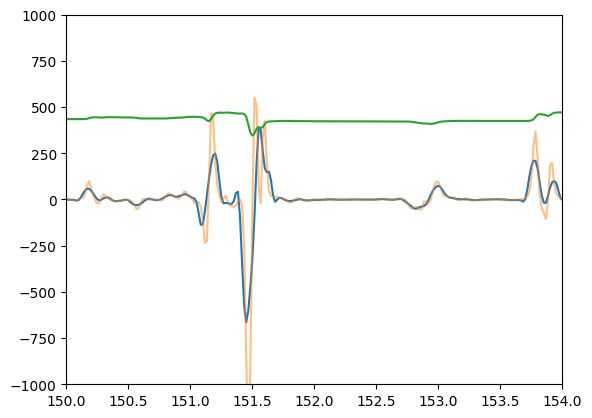

In [36]:
plt.plot(left_speeds[0], left_speeds[1])
plt.plot(left_speeds_nosmooth[0], left_speeds_nosmooth[1], alpha=.5)
plt.plot(design_matrix['Bin'], design_matrix['l_paw_x']-500)
plt.xlim([150, 154])
plt.ylim([-1000, 1000])

/tmp/ipykernel_10125/588091498.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 1].legend()


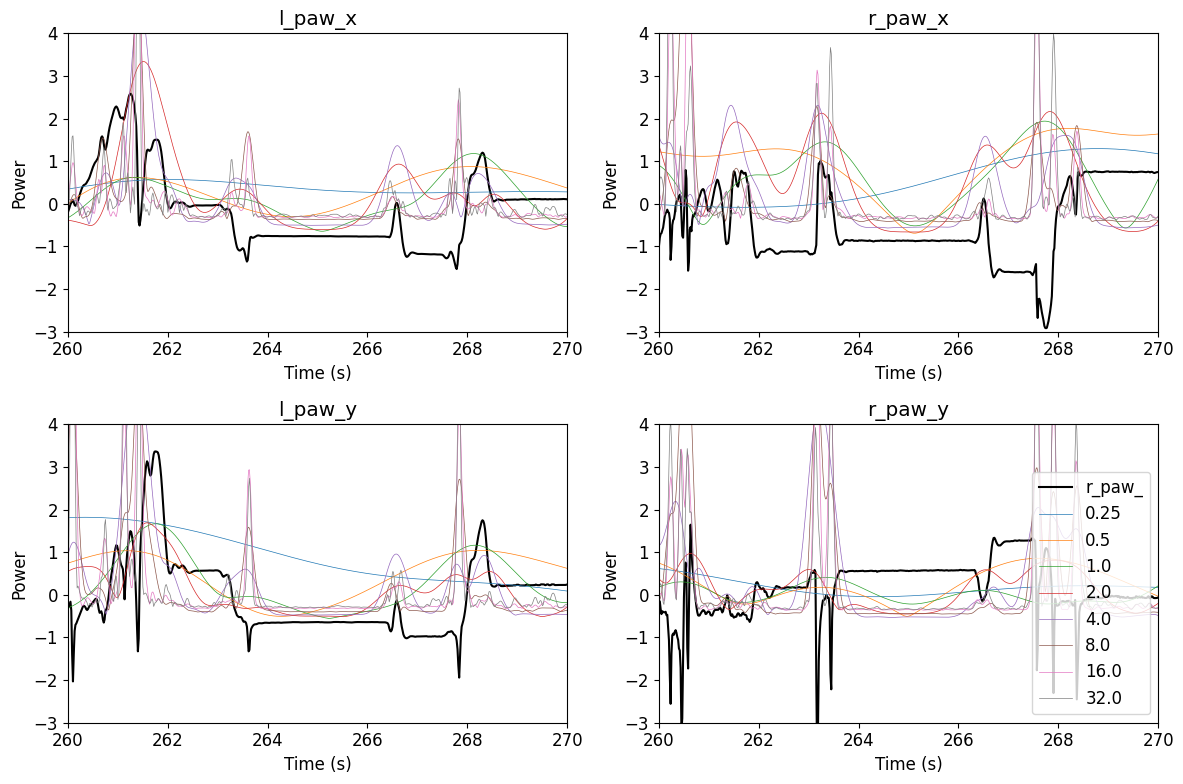

In [426]:
init = 260
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
for v, var in enumerate(['l_paw_', 'r_paw_']):
    for c, coor in enumerate(['x', 'y']):
        ax[c, v].plot(design_matrix['Bin'], stats.zscore(design_matrix[var+coor], nan_policy='omit'), label=var, color='k')
        # Wavelet transforms
        for i, frequency in enumerate(f):
            ax[c, v].plot(design_matrix['Bin'], stats.zscore(design_matrix[var+coor+str(frequency)], 
                                                             nan_policy='omit'), label=str(frequency), linewidth=.5)
            ax[c, v].set_xlim([init, init+10])
            ax[c, v].set_ylim([-3, 4])
            ax[c, v].set_ylabel('Power')
            ax[c, v].set_xlabel('Time (s)')
        ax[c, v].set_title(var+coor)
    ax[1, 1].legend()
    plt.tight_layout()

# Wavelet clustering

In [395]:
var_interest = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']
use_vars = var_interest[:4]

In [396]:

data = np.array(stats.zscore(design_matrix[use_vars].dropna(), axis=0))
n_components = np.shape(data)[1]
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(data)
# pca = PCA(n_components)  # Reduce to 50 dimensions
# X_pca = pca.fit_transform(data)

<BarContainer object of 4 artists>

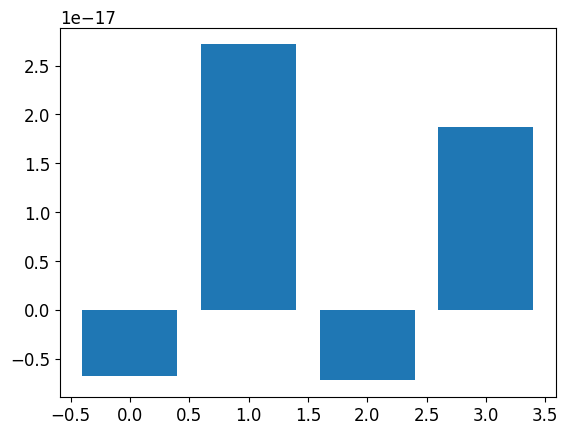

In [397]:
plt.bar(np.arange(0, np.shape(data)[1], 1), np.nanmean(stats.zscore(data, axis=0), axis=0))
# plt.bar(np.arange(0, 24, 1), np.nanmean(data, axis=0))
# plt.xlim([100, 200])

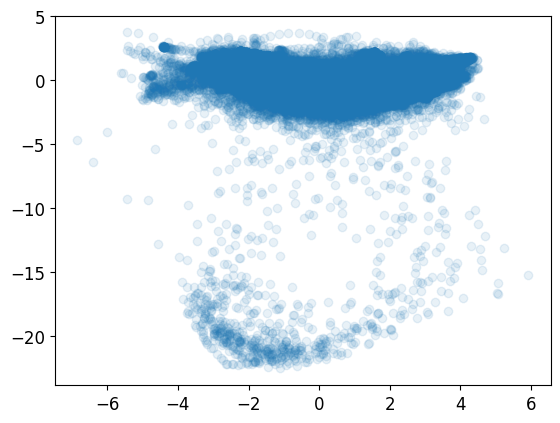

In [398]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=.1)

(0.0, 1.0)

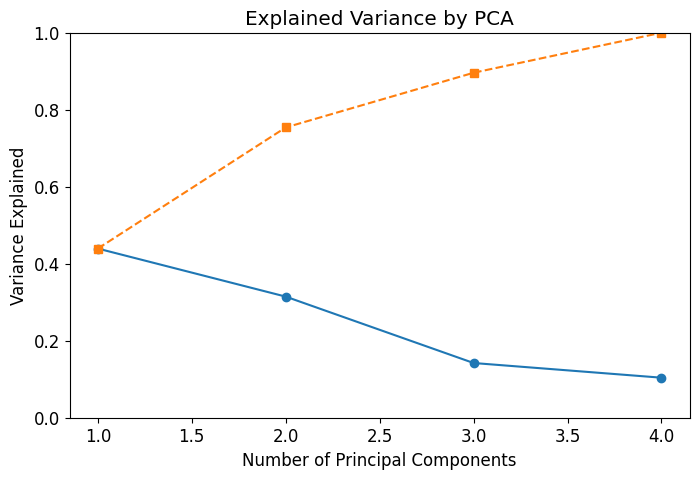

In [399]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")
plt.ylim([0, 1])

In [400]:
keep_components = np.min(np.where(cumulative_variance>0.89))
print(keep_components)

2


# Find best k

In [401]:
use_data = X_pca[:, :keep_components].copy()
# use_data = X_embedded.copy()
# use_data = data.copy()

repeats = 1
components = np.array([1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
# components = np.array([1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 40, 60, 100, 500, 1000])
components = np.arange(1, 21, 1)
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(use_data.copy(), components)
kneedle = KneeLocator(components[1:], np.nanmean(LLs, axis=0)[1:], curve="convex", direction="decreasing")
kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee

KeyboardInterrupt: 

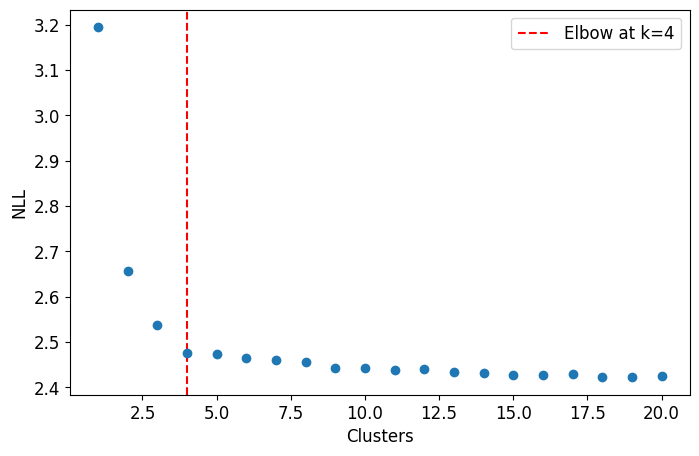

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components, np.nanmean(LLs, axis=0), np.nanstd(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

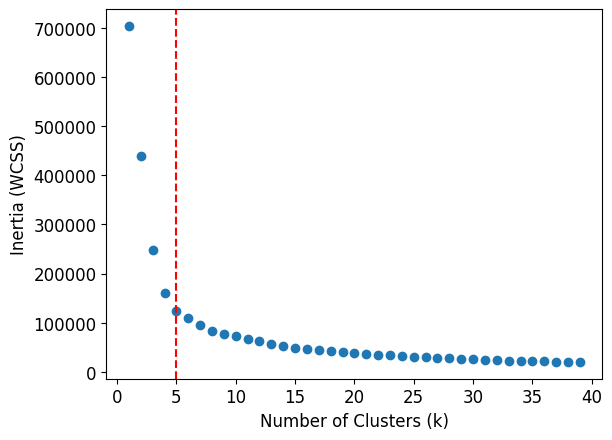

In [ ]:
# Assuming `X` is your data
inertia_values = []
K = range(1, 40)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(use_data)[0]*0.8)
    X_train = np.vstack([use_data[:cutoff, 0], use_data[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.show()

# kMeans on supersession

In [ ]:
keep_components = 4
use_data = X_pca[:, :keep_components].copy()
# use_data = X_embedded.copy()
use_data = data.copy()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=2024)
# kmeans.fit(concatenated_subsampled[:, :4].copy())
kmeans.fit(use_data.copy())
centroids = kmeans.cluster_centers_

In [ ]:
var_array = np.array(design_matrix[use_vars].copy())
not_nan = ~np.isnan(var_array).any(axis=1)
    
""" Compute clusters based on supersession centroids """
# Compute distances between full dataset and trained centroids
distances = cdist(use_data, centroids, metric='euclidean')
# Assign each point to the nearest centroid
states = np.argmin(distances, axis=1)

design_matrix['paw_states'] = np.nan
design_matrix['paw_states'][not_nan] = states

/tmp/ipykernel_10125/389541204.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_10125/389541204.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

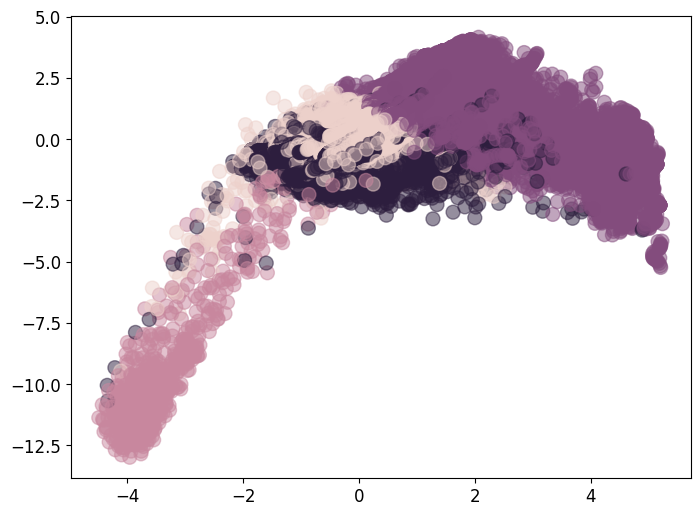

In [ ]:
# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))
cluster_values = states
# Plot each cluster with a different color
scatter = ax.scatter(use_data[:, 0], use_data[:, 1], c=cluster_values, s=100, alpha=.5, cmap=sns.cubehelix_palette(as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))


In [ ]:
use_data = design_matrix.copy()
wavelet_vars = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']

paw_vars = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']
paw_df = pd.melt(use_data, id_vars=['paw_states'], value_vars=paw_vars)

wavelet_df = pd.melt(use_data, id_vars=['paw_states'], value_vars=wavelet_vars)

<Axes: xlabel='paw_states', ylabel='value'>

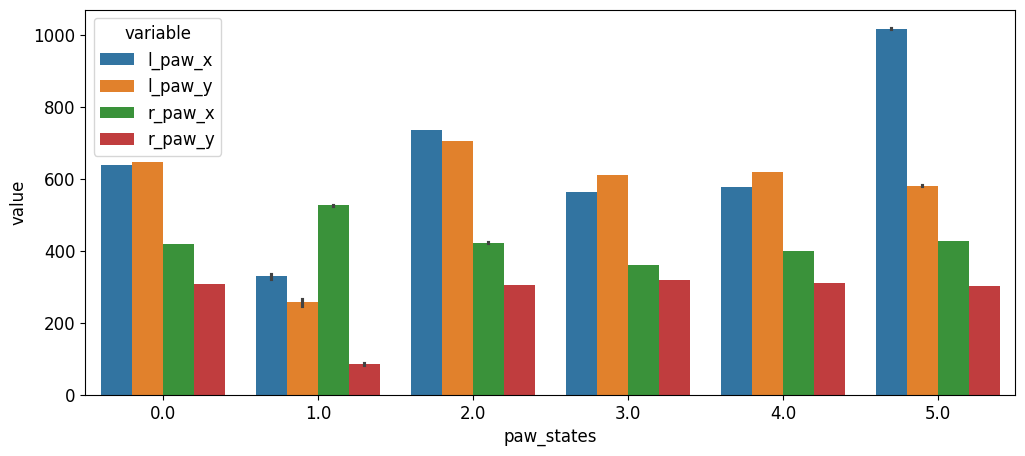

In [ ]:
plt.figure(figsize=[12, 5])
sns.barplot(x='paw_states', y='value', hue='variable', data=paw_df)

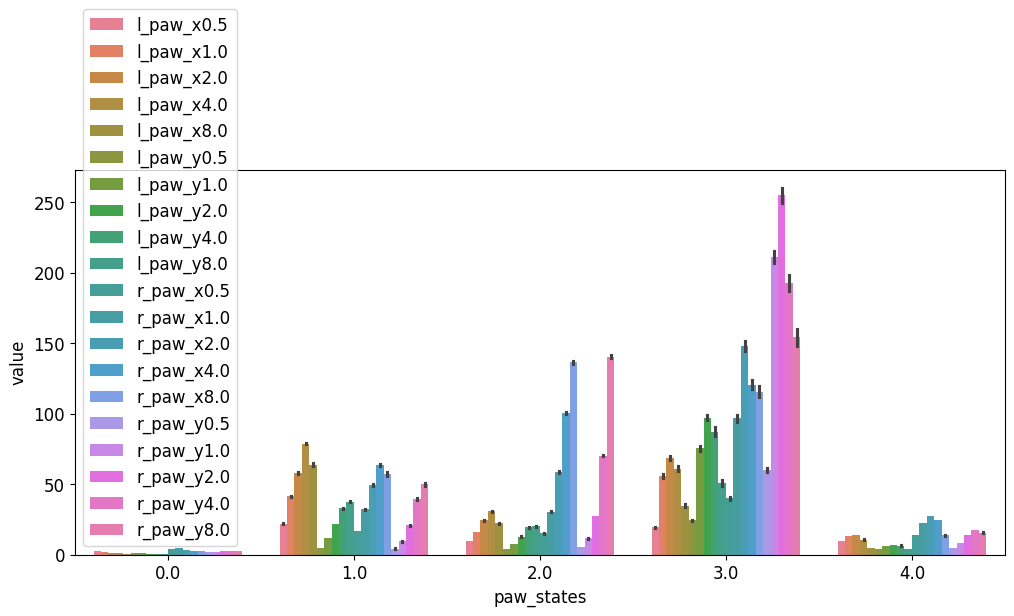

In [ ]:
plt.figure(figsize=[12, 5])
sns.barplot(x='paw_states', y='value', hue='variable', data=wavelet_df)
plt.legend()

In [ ]:
palette = sns.color_palette('Set1', n_colors=optimal_k, as_cmap=True)

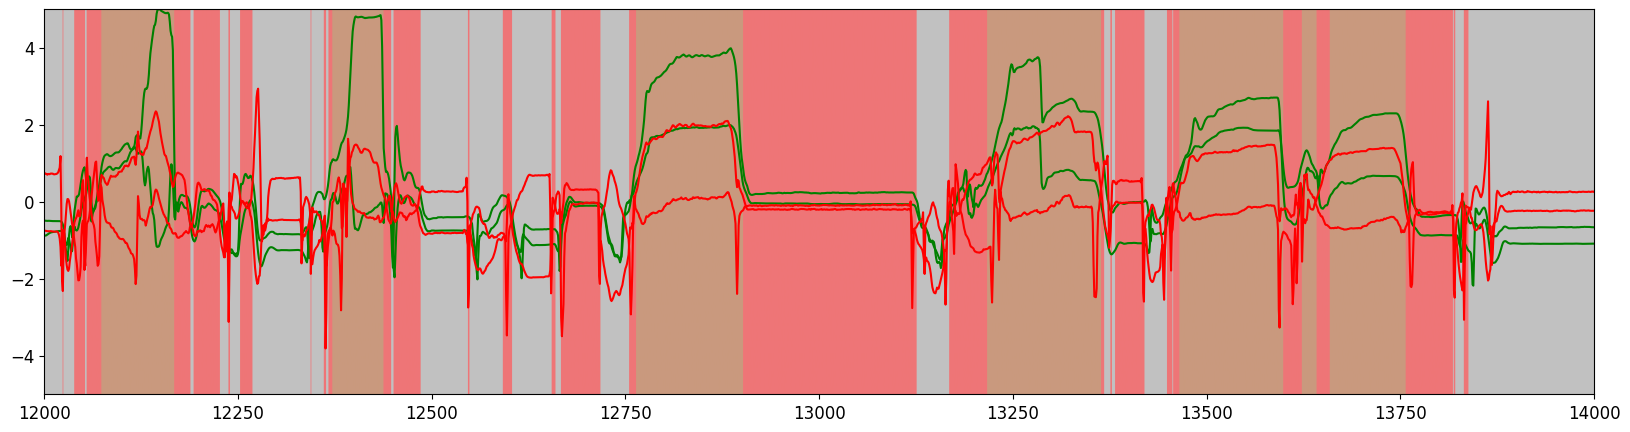

In [ ]:

fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
plt.rc('font', size=12)
init = 000
# ax.plot(design_matrix.loc[design_matrix['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_y'].reset_index()['l_paw_y'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_x'].reset_index()['r_paw_x'], nan_policy='omit'), color='red')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_y'].reset_index()['r_paw_y'], nan_policy='omit'), color='red')
attach_array = np.arange(0, optimal_k, 1)
ax.imshow(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])[None,:],
            extent=(0, len(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])), -10, 10),
            aspect="auto",
            alpha=0.6,
            cmap=palette)  # 
init=12000
plt.xlim([init, init+2000])
plt.ylim([-5, 5])
plt.show()

(array([87474.,     0.,   653.,     0., 32909.,     0., 56018.,     0.,
        85214.,  5623.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

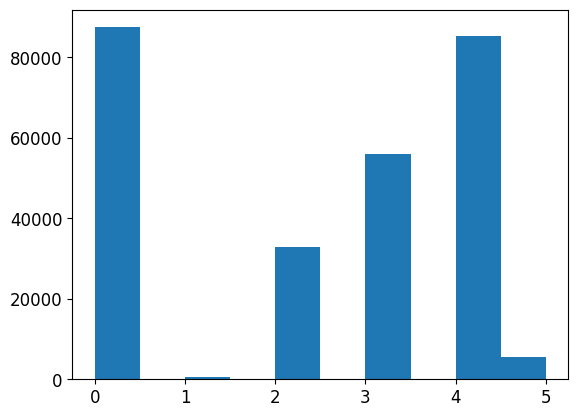

In [ ]:
plt.hist(design_matrix['paw_states'])